In [31]:
import numpy as np
import pandas as pd
import datetime as dt

In [32]:
def read_events(filepath):
    # This function reads events from a given json file and
    # creates the pandas dataframe.
    
    events_df = pd.read_json(filepath)
    events_df_reorganized = pd.DataFrame(list(events_df["events"]))
    
    # deleting rows that contain None elements
    events_df_reorganized = events_df_reorganized.mask(events_df_reorganized.eq('None')).dropna()
    # setting correct type for price
    events_df_reorganized["price"] = events_df_reorganized["price"].astype(float)
    return events_df_reorganized


In [33]:
def read_meta(filepath):
    # This function reads metadata from a given json file 
    # and creates the pandas dataframe.
    # Rows that contain None are also removed
    
    meta_df = pd.read_json(filepath)
    meta_df_reorganized = pd.DataFrame(list(meta_df["meta"]))
    
    meta_df_reorganized=meta_df_reorganized.mask(meta_df_reorganized.eq('None')).dropna()
    
    return meta_df_reorganized

In [34]:
events_df_reorganized = read_events(filepath = '../events.json')
events_df_reorganized.head()

,event,sessionid,eventtime,price,productid
0,cart,a0655eee-1267-4820-af21-ad8ac068ff7a,2020-06-01T08:59:16.406Z,14.48,HBV00000NVZE8
1,cart,d2ea7bd3-9235-4a9f-a9ea-d7f296e71318,2020-06-01T08:59:46.580Z,49.90,HBV00000U2B18
2,cart,5e594788-78a0-44dd-8e66-37022d48f691,2020-06-01T08:59:33.308Z,1.99,OFIS3101-080
3,cart,fdfeb652-22fa-4153-b9b5-4dfa0dcaffdf,2020-06-01T08:59:31.911Z,2.25,HBV00000NVZBW
4,cart,9e9d4f7e-898c-40fb-aae9-256c40779933,2020-06-01T08:59:33.888Z,9.95,HBV00000NE0T4


In [35]:
meta_df_reorganized = read_meta('../meta.json')
meta_df_reorganized.head()

,productid,brand,category,subcategory,name
0,HBV00000AX6LR,Palette,Kişisel Bakım,Saç Bakımı,Palette Kalıcı Doğal Renkler 10-4 PAPATYA
1,HBV00000BSAQG,Best,Pet Shop,Kedi,Best Pet Jöle İçinde Parça Etli Somonlu Konser...
2,HBV00000JUHBA,Tarım Kredi,Temel Gıda,"Bakliyat, Pirinç, Makarna",Türkiye Tarım Kredi Koop.Yeşil Mercimek 1 kg
3,HBV00000NE0QI,Namet,"Et, Balık, Şarküteri",Şarküteri,Namet Fıstıklı Macar Salam 100 gr
4,HBV00000NE0UQ,Muratbey,Kahvaltılık ve Süt,Peynir,Muratbey Burgu Peyniri 250 gr


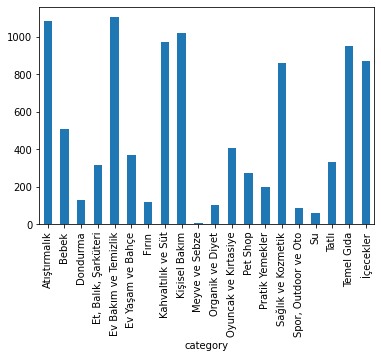

In [36]:
# Distribution of products in metadata according to category information
import matplotlib.pyplot as plt
serie=meta_df_reorganized.groupby('category')['category'].count()
serie.plot.bar()

plt.show()

In [77]:
def filter_category(df, category):
    df = df.loc[df['category'] != category]
    
    return df

In [38]:
# since there are so little products for Meyve ve Sebze category, I didnt use these products to create recommender systems
meta_df_reorganized = filter_category(meta_df_reorganized, 'Meyve ve Sebze')
meta_df_reorganized.head()

,productid,brand,category,subcategory,name
0,HBV00000AX6LR,Palette,Kişisel Bakım,Saç Bakımı,Palette Kalıcı Doğal Renkler 10-4 PAPATYA
1,HBV00000BSAQG,Best,Pet Shop,Kedi,Best Pet Jöle İçinde Parça Etli Somonlu Konser...
2,HBV00000JUHBA,Tarım Kredi,Temel Gıda,"Bakliyat, Pirinç, Makarna",Türkiye Tarım Kredi Koop.Yeşil Mercimek 1 kg
3,HBV00000NE0QI,Namet,"Et, Balık, Şarküteri",Şarküteri,Namet Fıstıklı Macar Salam 100 gr
4,HBV00000NE0UQ,Muratbey,Kahvaltılık ve Süt,Peynir,Muratbey Burgu Peyniri 250 gr


In [76]:
meta_df_reorganized['category'].unique()

array(['Kişisel Bakım', 'Pet Shop', 'Temel Gıda', 'Et, Balık, Şarküteri',
       'Kahvaltılık ve Süt', 'Su', 'Fırın', 'Oyuncak ve Kırtasiye',
       'Ev Bakım ve Temizlik', 'Atıştırmalık', 'Tatlı', 'Bebek',
       'Ev Yaşam ve Bahçe', 'Sağlık ve Kozmetik', 'Pratik Yemekler',
       'Organik ve Diyet', 'İçecekler', 'Dondurma',
       'Spor, Outdoor ve Oto'], dtype=object)

In [50]:
def remove_no_metadata_products(meta_df_reorganized, events_df_reorganized):
    # There are some records in events_df which are not available in meta_df
    # Therefore this function removes events whose product ids are not
    # present in the metadata
    meta=list(set(meta_df_reorganized["productid"].values))
    return events_df_reorganized[events_df_reorganized['productid'].isin(meta)]

In [40]:
remove_no_metadata_products(meta_df_reorganized, events_df_reorganized).shape

(255499, 5)

In [53]:
def filter_negative_price(events_df_reorganized):
    return events_df_reorganized[ events_df_reorganized["price"] > 0 ]    

In [54]:
def format_dataframe(events_df_reorganized):
    # This function removes unused columns and prepares events_df
    
    # Since there is only 'cart' event, this column is dropped
    events_df_reorganized = events_df_reorganized.drop(columns="event")
    # In session-based and content-based recommender, I didn't utilized price information, price columnn dropped
    events_df_reorganized = events_df_reorganized.drop(columns="price")
    # Converting eventtime column to more readable format to make comprasion and observion easier
    events_df_reorganized['time']=events_df_reorganized['eventtime'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ').timestamp())
    # After conversion, time column created and eventtime dropped
    events_df_reorganized = events_df_reorganized.drop(columns="eventtime")
    return events_df_reorganized

In [55]:
def remove_unpopular_items(events_df_reorganized):
    # Delete session informations' that bought unpopular items (items that bought by less than 5 sessions)
    item_supports = events_df_reorganized.groupby('productid').size()
    events_df_reorganized = events_df_reorganized[np.in1d(events_df_reorganized.productid, item_supports[item_supports>=5].index)]
    return events_df_reorganized

In [56]:
def remove_single_item_purchase_sessions(events_df_reorganized):
    # This function deletes session informations' that bought only one item
    
    session_lengths = events_df_reorganized.groupby('sessionid').size()
    events_df_reorganized = events_df_reorganized[np.in1d(events_df_reorganized.sessionid, session_lengths[session_lengths>1].index)]
    return events_df_reorganized

In [59]:
def preprocessing_job():
    events_df_reorganized = read_events(filepath = '../events.json')
    meta_df_reorganized = read_meta('../meta.json')

    meta_df_reorganized = filter_category(meta_df_reorganized, 'Meyve ve Sebze')
    events_df_reorganized = remove_no_metadata_products(meta_df_reorganized, events_df_reorganized)
    events_df_reorganized = filter_negative_price(events_df_reorganized)
    events_df_reorganized = format_dataframe(events_df_reorganized)
    events_df_reorganized = remove_single_item_purchase_sessions(events_df_reorganized)
    events_df_reorganized = remove_unpopular_items(events_df_reorganized)
    # Here we remove single item purchase sessions again because removing unpopular items above 
    # caused some single purchase sessions
    events_df_reorganized = remove_single_item_purchase_sessions(events_df_reorganized)
    
    # store results in output folder
    events_df_reorganized.to_csv("output/events_df_reorganized2.csv", sep=',', encoding='utf-8')
    meta_df_reorganized.to_csv("output/meta_df_reorganized2.csv", sep=',', encoding='utf-8')

['HBV00000PQLMZ', 'PTLIENJ03', 'HBV00000SPBBZ', 'HBV00000NFHCK', 'AILEMLP5001063', 'HBV00000PNGL4', 'HBV00000OE88X', 'HBV00000PQJWY', 'ZYHPDROETTTL048', 'HBV00000PQL2Q', 'HBV00000NE0TU', 'HBV00000SP74S', 'ZYBICN9286533', 'HBV00000PV97K', 'SGDEGVEETSHKRNRML', 'HBV00000NE18R', 'HBV00000NE1X2', 'HBV00000PVCMO', 'HBV00000U271V', 'HBV00000PQJVP', 'HBV00000UIYEF', 'HBV00000NGSTI', 'HBV00000B07LZ', 'SGDRX3603', 'HBV00000PQOWR', 'HBV00000U2B34', 'ZYDOGUS8607264GR', 'HBV00000U27PM', 'HBV00000SP80N', 'HBV00000EEF8P', 'HBV00000LZI6J', 'HBV00000NG8PP', 'HBV00000PV7KP', 'HBV000005CV1G', 'HBV00000NFHB1', 'HBV00000D1O53', 'ZYEREN274', 'HBV00000NFGUV', 'HBV00000PQJC1', 'HBV00000QX24L', 'SGKLSTNNTRLS573', 'ZYCADB761450001001', 'HBV00000PQM06', 'HBV00000HN082', 'HBV00000SP842', 'HBV00000SP6X2', 'ZYHPPEPSIGZS021', 'HBV00000U2B1Q', 'HBV00000PVQB2', 'HBV00000NFGWX', 'HBV00000PQKCB', 'HBV00000PQKBC', 'HBV00000PV9D5', 'SGGIL243548', 'ZYNES12206045', 'HBV00000PVBH3', 'ZYBICN9286940', 'HBV00000AX6JH', 'HBV0000

(255499, 3)
(235058, 3)
(234604, 3)


In [102]:
import unittest

class TestPreprocessing(unittest.TestCase):
    
    def test_filter_category(self):
        
        meta_df = pd.DataFrame()
        meta_df['category'] = ['C1','C2','C3','C1','C1']
        result = filter_category(meta_df, 'C1')
        
        # Check if there are 2 elements after filtering category C1
        self.assertEqual(len(result), 2)
        # Check if C1 is removed        
        self.assertTrue('C1' not in result['category'])
    
    
    def test_remove_no_metadata_products(self):
        
        meta_df = pd.DataFrame()
        meta_df['productid'] = [1,2,3,4,5]
        
        events_df = pd.DataFrame()
        events_df['productid'] = [1,2,3,4,5,6,7,8,9,10]
        
        result = remove_no_metadata_products(meta_df, events_df)
        
        # Check if there are 5 elements after removing
        self.assertEqual(len(result), 5)
        # Check if only 1,2,3,4,5 are in the result
        self.assertEqual(list(result['productid']), [1,2,3,4,5])
        
        
    def test_filter_negative_price(self):
        
        events_df = pd.DataFrame()
        events_df['price'] = [1,-1,10,-10,3]
        
        result = filter_negative_price(events_df)
        
        # Check if there are 3 elements after removing
        self.assertEqual(len(result), 3)
        # Check if there are no negative elements
        self.assertEqual(len(set(result['price'] < 0)), 1)
        
        
    def test_format_dataframe(self):
        
        events_df = pd.DataFrame()
        events_df['event'] = ['cart','cart','cart']
        events_df['price'] = [1,2,3]
        events_df['sessionid'] = [11,22,33]
        events_df['productid'] = [11,22,33]
        events_df['eventtime'] = ['2020-06-01T08:59:16.406Z', '2020-06-02T08:59:16.406Z', '2020-06-03T08:59:16.406Z']
        
        result = format_dataframe(events_df)
        
        # Check if there are 3 columns after removing
        self.assertEqual(len(result.columns), 3)
    
    def test_remove_single_item_purchase_sessions(self):
        events_df = pd.DataFrame()
        events_df['event'] = ['cart','cart','cart']
        events_df['price'] = [1,2,3]
        events_df['sessionid'] = [11,22,22]
        events_df['productid'] = [11,22,33]
        events_df['eventtime'] = ['2020-06-01T08:59:16.406Z', '2020-06-02T08:59:16.406Z', '2020-06-03T08:59:16.406Z']
        
        result = remove_single_item_purchase_sessions(events_df)
        
        # Check if only 22 is in the sesionid column
        self.assertEqual(list(result['sessionid']), [22,22])
        
    def test_remove_unpopular_items(self):
        events_df = pd.DataFrame()
        events_df['sessionid'] = [11,22,33,44,55,66]
        events_df['productid'] = [11,11,11,11,11,22]
        result = remove_unpopular_items(events_df)
        
        # Check if only 22 is in the sesionid column
        self.assertEqual(list(result['productid']), [11,11,11,11,11])
        

unittest.main(argv=[''], verbosity=2, exit=False)

test_filter_category (__main__.TestPreprocessing) ... ok
test_filter_negative_price (__main__.TestPreprocessing) ... ok
test_format_dataframe (__main__.TestPreprocessing) ... ok
test_remove_no_metadata_products (__main__.TestPreprocessing) ... ok
test_remove_single_item_purchase_sessions (__main__.TestPreprocessing) ... ok
test_remove_unpopular_items (__main__.TestPreprocessing) ... 

[1, 2, 3, 4, 5]
0     1
1     2
2     3
3     4
4     5
5     6
6     7
7     8
8     9
9    10
Name: productid, dtype: int64


ok

----------------------------------------------------------------------
Ran 6 tests in 0.018s

OK
